# <center> Butter-E Dataset Notebooks: Overview Figures </center>
---

This notebook contains the code to produce the marginal analysis / overview figures of the butter_e dataset.



In [1]:
import pandas as pd
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt

from common import *

# Ingest data

In [2]:
experiments = pd.read_parquet("./data_artifacts/experiments.pq")

# Figures

In [3]:
def plot_datasum(
    selection,
    group_col="depth",
    unique_groups=[4, 8, 16],
    x_col="size",
    y_col="energy_per_training_datum",
    group_linestyle="--",
):
    """
    Plots energy per epoch per observation against the number of observations, grouped by depth and size.

    Parameters:
        - selection (DataFrame): Input data containing columns 'n_observations', 'size', 'depth', and 'energy_per_training_datum'.
        - group_col (str): Column name for grouping (default is "depth").
        - x_col (str): Column name for the x-axis (default is "size").
        - y_col (str): Column name for the y-axis (default is "energy_per_training_datum").
        - offset (float): Offset distance (default is 1000).
        - log_space_offset (bool): Flag to indicate whether to use log space offset (default is False).
        - title (str): Plot taitle (default is "Energy per Epoch per Observation vs Size").
    """
    # Create a figure and axis
    # fig, ax = plt.subplots(figsize=(20, 10))
    ax = plt.gca()

    selection_cpu = selection.query("has_gpu==False")
    selection_gpu = selection.query("has_gpu==True")

    ## GPU Median Line
    gpu_quantiles = selection_gpu.groupby([x_col])[y_col].quantile([0.25, 0.5, 0.75])
    ax.plot(
        gpu_quantiles[:, 0.5].index,
        gpu_quantiles[:, 0.5],
        label="GPU",
        # color="gray",
        color=gpu_color,
        linewidth=3,
        alpha=0.8,
    )

    ## CPU Median Line
    global_quantiles = selection_cpu.groupby([x_col])[y_col].quantile([0.25, 0.5, 0.75])
    ax.plot(
        global_quantiles[:, 0.5].index,
        global_quantiles[:, 0.5],
        label="Median",
        # color="black",
        color=cpu_color,
        linewidth=3,
        alpha=0.8,
    )

    # scatter_sample = selection_cpu.sample(5000)
    # ax.scatter(
    #    scatter_sample[x_col],
    #    scatter_sample[y_col],
    #     color=cpu_color,
    #     linewidth=3,
    #     alpha=0.01,
    #     marker=',',
    #     s=1,
    #     lw=0,
    # )

    ## Error bars
    ax.vlines(
        x=global_quantiles[:, 0.5].index,
        ymin=global_quantiles[:, 0.25],
        ymax=global_quantiles[:, 0.75],
        # color="black",
        color=cpu_color,
        linewidth=1,
    )

    ## Group Medians
    for i, group in enumerate(unique_groups):
        group_data = selection_cpu[selection_cpu[group_col] == group]
        group_quantiles = group_data.groupby([x_col])[y_col].quantile([0.25, 0.5, 0.75])

        ax.plot(
            group_quantiles[:, 0.5].index,
            group_quantiles[:, 0.5],
            label=f"{str(group_col)}: {group}",
            linewidth=1,
            linestyle=group_linestyle,
        )

In [4]:
selection = experiments[
    (experiments["n_observations"] > 500)  # &
    # (butter_e_with_dataset["depth"]>3)
]

print(selection.head(10))

   experiment_id  depth   size    run_time         energy       power  \
0        1876157    3.0  256.0  132.909284   36530.898438  274.855896   
1        1876157    3.0  256.0  890.954438  392528.187500  440.570435   
2        1876158    3.0  128.0  148.261504   46225.441406  311.783173   
3        1876158    3.0  128.0  897.002413  382806.906250  426.762390   
4        1876164    3.0   64.0  142.948750   42499.347656  297.304810   
5        1876164    3.0   64.0  877.166334  362879.562500  413.695251   
6        1876166    3.0  512.0  150.876892   45003.164062  298.277374   
7        1876166    3.0  512.0  884.746991  395962.250000  447.542908   
8        1876167    3.0   32.0  195.736277   58750.839844  300.153046   
9        1876167    3.0   32.0  888.005653  380866.406250  428.900879   

      std_energy   std_power  energy_overhead  non_overhead_energy  ...  \
0   36530.898438  274.855896     14028.666016         22502.232422  ...   
1  366690.500000  411.570435    271560.250000 

In [5]:
experiments["flops_per_epoch"] = (
    experiments["num_training_batches_per_epoch"]
    * (experiments["fwd_operations"] + experiments["bwd_operations"])
    + experiments["num_test_batches_per_epoch"] * experiments["fwd_operations"]
)
experiments["flops_per_training_datum"] = experiments["flops_per_epoch"] / (
    experiments["num_training_batches_per_epoch"] * experiments["batch_size"]
)

/tmp/ipykernel_1437/1681080749.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1437/1681080749.py:191: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in legend.legendHandles:


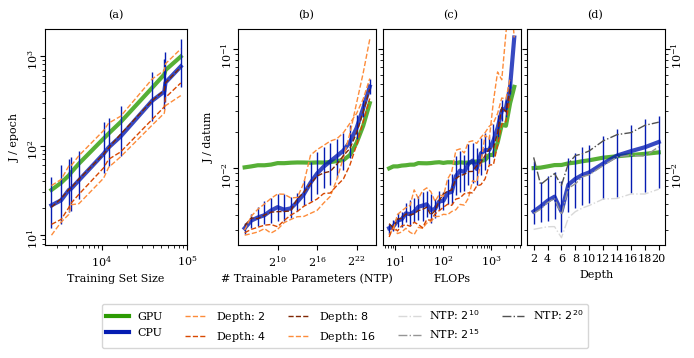

In [6]:
# plt fontsize
import matplotlib


plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 8


# Final Selection of DAta

selection = experiments[
    (experiments["n_observations"] > 500)  # &
    # (butter_e_with_dataset["depth"]>3)
]

size_colors = plt.cm.Greys(np.linspace(0.25, 1, 4))
depth_colors = plt.cm.Oranges(np.linspace(0.25, 1, 4)[1:])

# ====================================================================================================

# fig, axs = plt.subplots(1, 4, figsize=(8, 3))
fig = plt.figure(figsize=(8, 2.8))
axs = []
outer_grid = fig.add_gridspec(1, 2, width_ratios=[1, 3], wspace=0.18)
right_grid = matplotlib.gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer_grid[1], wspace=0.05
)
# make nested gridspecs
# gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
# gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = .05)

# change to the first axes
# ax = outer_grid[0] #axs[0]
ax = plt.subplot(outer_grid[0])
axs.append(ax)
plt.sca(ax)
ax.set_prop_cycle(color=depth_colors)
# ax.set_prop_cycle(color=pallette[0])
plot_datasum(
    selection,
    group_col="depth",
    unique_groups=[2, 4, 8, 16],
    x_col="traning_data_per_epoch",
    y_col="energy_per_epoch",
)

ax.set_xlabel("Training Set Size")
ax.set_ylabel("J / epoch")
ax.set_xscale("log")
ax.set_yscale("log")
# set the legend for the first axes outside the plot
# ax.legend()
ax.tick_params(axis="y", labelrotation=90, pad=0)
ax.tick_params(axis="x", pad=3)


# ====================================================================================================
# change to the second axes
ax = plt.subplot(right_grid[0])
axs.append(ax)
second_ax = ax
plt.sca(ax)

ax.set_prop_cycle(color=depth_colors)
# ax.set_prop_cycle(color=pallette[0])
plot_datasum(
    selection,
    unique_groups=[2, 4, 8, 16],
    group_col="depth",
    x_col="size",
    y_col="energy_per_training_datum",
)

ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("# Trainable Parameters (NTP)")
ax.set_ylabel("J / datum")
ax.tick_params(axis="y", labelrotation=90, pad=0)
ax.tick_params(axis="x", pad=3)
# axs[1].legend()

# ====================================================================================================
# change to the third axes
# ax = right_grid[1]
ax = plt.subplot(right_grid[1])
axs.append(ax)
plt.sca(ax)

ax.set_prop_cycle(color=depth_colors)
# ax.set_prop_cycle(color=pallette[0])
selection["flops_per_training_datum_rounded"] = np.exp(
    (5 * np.log10(selection["flops_per_training_datum"])).round(0) / 5
)
plot_datasum(
    selection,
    unique_groups=[2, 4, 8, 16],
    group_col="depth",
    x_col="flops_per_training_datum_rounded",
    y_col="energy_per_training_datum",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(second_ax.get_ylim())
ax.set_xlabel("FLOPs")
# ax.set_ylabel("J / datum")
ax.tick_params(axis="y", labelrotation=90, pad=0)
ax.tick_params(axis="x", pad=3)
ax.tick_params(
    axis="y",
    which="both",
    left=True,
    right=False,
    labelleft=False,
    labelright=False,
)

# ====================================================================================================

# change to the fourth axes
# ax = right_grid[2]
ax = plt.subplot(right_grid[2])
axs.append(ax)
plt.sca(ax)
ax.set_prop_cycle(color=size_colors)
# ax.set_prop_cycle(color=pallette[3])
plot_datasum(
    selection,
    group_col="size",
    unique_groups=[2**10, 2**15, 2**20],
    x_col="depth",
    y_col="energy_per_training_datum",
    group_linestyle="-.",
)

ax.set_xlabel("Depth")
# ax.set_ylabel("J / datum")
# set the y limits for the third axes to be the same as the second axes
ax.set_ylim(second_ax.get_ylim())
# set ax x axis to be integers
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_yscale("log")
ax.tick_params(axis="y", labelrotation=90, pad=0)
ax.tick_params(axis="x", pad=3)
ax.tick_params(
    axis="y",
    which="both",
    left=True,
    right=True,
    labelleft=False,
    labelright=True,
)

# ====================================================================================================

# show the legend outside the plot horizontally
handles1, labels1 = axs[1].get_legend_handles_labels()
labels1 = ["GPU", "CPU", "Depth: $2$", "Depth: $4$", "Depth: $8$", "Depth: $16$"]

handles2, labels2 = axs[-1].get_legend_handles_labels()
labels2 = ["GPU", "CPU", "NTP: $2^{10}$", "NTP: $2^{15}$", "NTP: $2^{20}$"]

# combine the handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# remove the first handle and label
handles = handles[:6] + handles[8:]
labels = labels[:6] + labels[8:]

# add (a), (b), (c) to the subplots as small text
for i, ax in enumerate(axs):
    ax.text(
        0.55,
        1.09,
        f"({chr(97+i)})",
        transform=ax.transAxes,
        fontsize=8,
        va="top",
        ha="right",
    )


plt.tight_layout()
plt.subplots_adjust(wspace=0.31)
legend = fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=5
)

for h in legend.legendHandles:
    h.set_alpha(1.0)

plt.savefig("figures/3_figures.svg", dpi=600, bbox_inches="tight")
plt.savefig("figures/3_figures.png", dpi=600, bbox_inches="tight")
plt.show()

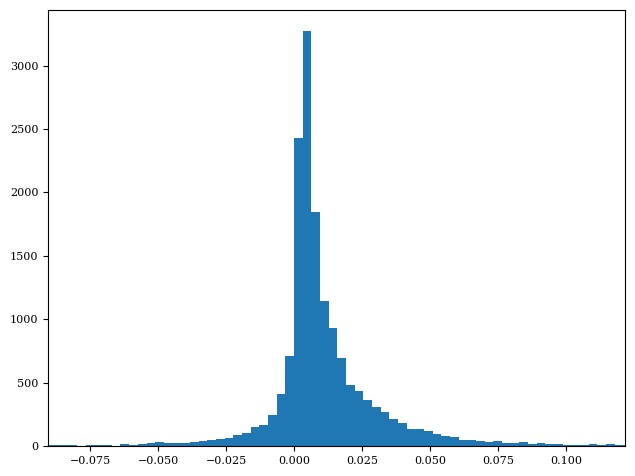

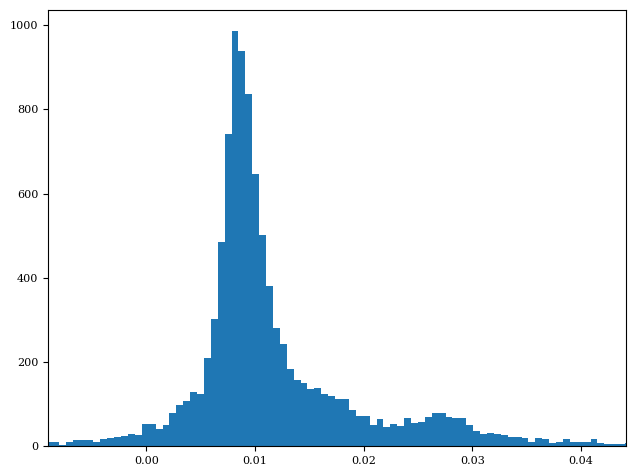

CPU quantiles: [0.00241215 0.00616453 0.0163196 ]
GPU quantiles: [0.00770497 0.00947002 0.01375093]


In [7]:
# get data for ax1
selection = experiments[(experiments["n_observations"] > 500)]

cpu = selection.query("has_gpu==False")
gpu = selection.query("has_gpu==True")


def getmarginalslope(query, splitCols, xcol, ycol="energy_per_training_datum"):
    slopes = []

    def helper(splitCols, query):
        if len(splitCols) == 0:
            uniqueXcol = sorted(query[xcol].unique())
            for i in range(len(uniqueXcol) - 1):
                left = uniqueXcol[i]
                right = uniqueXcol[i + 1]
                leftsubset = query.loc[query[xcol] == left, ycol].median()
                rightsubset = query.loc[query[xcol] == right, ycol].median()
                rise = rightsubset - leftsubset
                run = right - left
                slope = rise / run
                slopes.append(slope)
        else:
            splitCol = splitCols[0]
            splitCols = splitCols[1:]
            for split in query[splitCol].unique():
                helper(splitCols, query.loc[query[splitCol] == split])

    helper(splitCols, query)
    plt.hist(slopes, bins=len(slopes) // 5)
    plt.tight_layout()
    plt.xlim(*np.quantile(slopes, [0.01, 0.99]))
    plt.show()
    return np.quantile(slopes, [0.25, 0.5, 0.75])


cpuquantiles = getmarginalslope(
    cpu, ["shape", "depth", "size"], "n_observations", "energy_per_epoch"
)
gpuquantiles = getmarginalslope(
    gpu, ["shape", "depth", "size"], "n_observations", "energy_per_epoch"
)

print(f"CPU quantiles: {cpuquantiles}")
print(f"GPU quantiles: {gpuquantiles}")

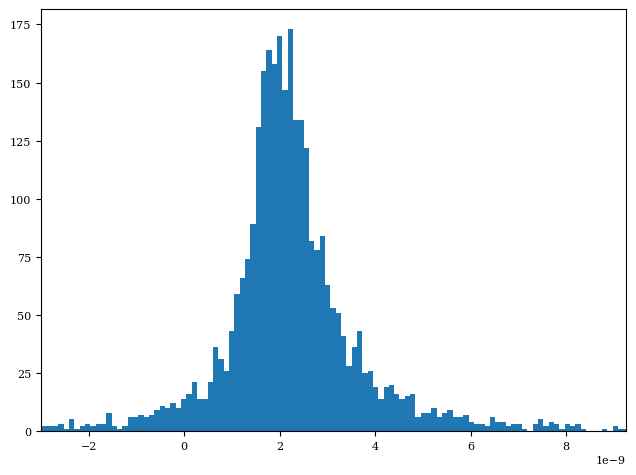

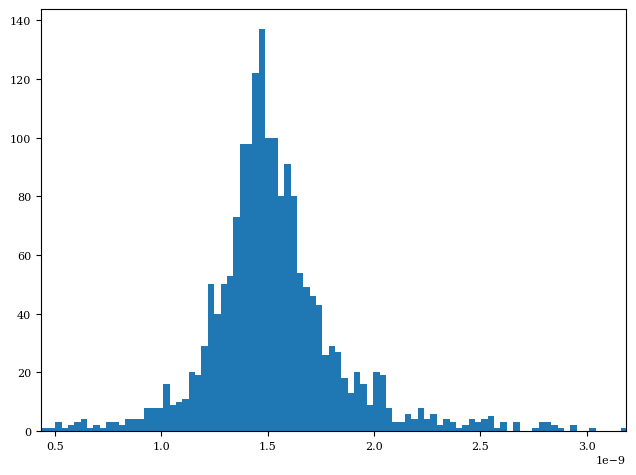

CPU quantiles: [1.57045657e-09 2.11097474e-09 2.80853624e-09]
GPU quantiles: [1.37026455e-09 1.49482819e-09 1.65585363e-09]


In [8]:
cpuquantiles = getmarginalslope(
    cpu.loc[cpu["size"] >= 2**21],
    ["shape", "depth", "dataset"],
    "size",
    "energy_per_training_datum",
)
gpuquantiles = getmarginalslope(
    gpu.loc[gpu["size"] > 2**20],
    ["shape", "depth", "dataset"],
    "size",
    "energy_per_training_datum",
)

print(f"CPU quantiles: {cpuquantiles}")
print(f"GPU quantiles: {gpuquantiles}")

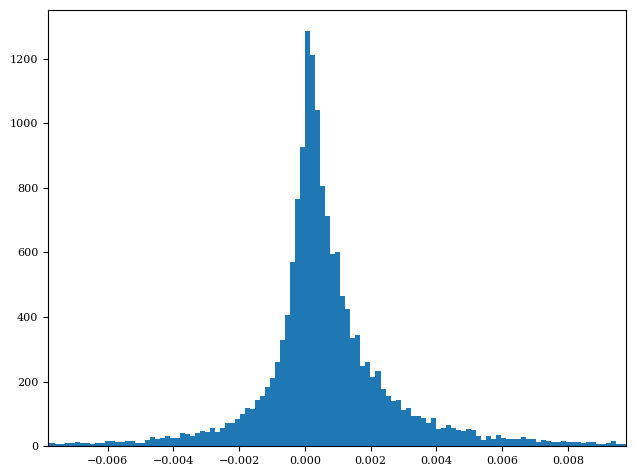

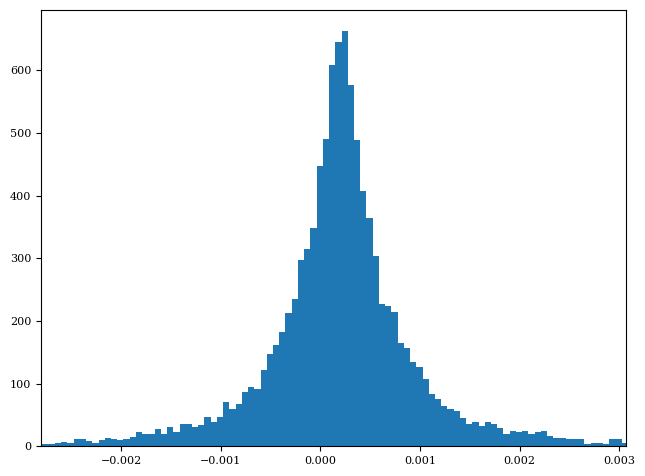

CPU quantiles: [-0.00020843  0.00036977  0.00134278]
GPU quantiles: [-0.00013756  0.00020335  0.00052772]


In [9]:
cpuquantiles = getmarginalslope(
    cpu, ["shape", "size", "dataset"], "depth", "energy_per_training_datum"
)
gpuquantiles = getmarginalslope(
    gpu, ["shape", "size", "dataset"], "depth", "energy_per_training_datum"
)

print(f"CPU quantiles: {cpuquantiles}")
print(f"GPU quantiles: {gpuquantiles}")